In [1]:
import gurobipy as grb
from gurobipy import GRB
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d

In [3]:
#load data
path = "./"
filename = "medium_instance.json"
#filename = "toy_instance.json"
with open(os.path.join(path, filename), "r") as f:
    data = json.load(f)
print(data.keys())

jobs_names = [job["name"] for job in data["jobs"]]
staff_names = [staff["name"] for staff in data["staff"]]
job_infos = {}

for job in data["jobs"]:
    job_infos[job["name"]] = {"gain": int(job["gain"]), "daily_penalty": int(job["daily_penalty"]), "due_date": int(job["due_date"]), "qualifications_needed": job["working_days_per_qualification"].keys() }

#ptite douille possible : changer les gains par un random eps pour "casser les symétries"

dict_keys(['horizon', 'qualifications', 'staff', 'jobs'])


In [4]:
#For medium instance 27*5 work days are needed to complete all projects 
# (just a sum over each work day per project)
#  with no regards to calendar & organization problem.

# But the horizon is fixed to 22, so the problem can not be finished in time...

s = 0
for job in data['jobs']:
    wpq = job['working_days_per_qualification']
    for w in wpq:
        s += wpq[w]
print("Number of work day needed per staff : ", s / len(data['staff']), "day/staff")

Number of work day needed per staff :  27.0 day/staff


In [5]:
N = dict()
for job in data["jobs"]:
    N[job["name"]] = {}
    for comp in data["qualifications"]:
        N[job["name"]][comp] = job["working_days_per_qualification"][comp] if comp in job["working_days_per_qualification"] else 0


In [6]:
tp_list = []

# create var 
for elem in data["staff"]:
    for jour in range(1, data["horizon"]+1):
        if jour in elem["vacations"]:
            continue
        for comp in elem["qualifications"]:
            for job in jobs_names:
                if comp in job_infos[job]["qualifications_needed"]:
                    tp_list.append((elem["name"], comp, jour, job))

# Create initial model.
model = grb.Model("Model")
T = model.addVars(grb.tuplelist(tp_list), vtype=GRB.BINARY, name="T")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-12


In [7]:
#Contraintes 1 à 3 déjà intégrées dans la création de T

#Contrainte 4 
model.addConstrs( (T.sum(staff, "*", jour, "*") <= 1 for staff in staff_names for jour in range(1, data["horizon"]+1)), name="unicite_travail");


In [8]:
# On souhaite que les collaborateurs n’aient pas
# à changer trop souvent de projet et, pour ce faire on s’attachera
# à minimiser le nombre de projets sur lesquels un quelconque collaborateur est affecté.

has_worked = {} #Pour chaque staff, = 1 si staff travaille au moins un jour sur job, 0 sinon
days_worked_on_job = {}
for staff in staff_names:
    has_worked[staff] = {}
    days_worked_on_job[staff] = {}
    for job in jobs_names:
        days_worked_on_job[staff][job] = model.addVar(vtype=GRB.INTEGER, name=f"workdays_of_{staff}_on_job_{job}")
        model.addConstr(days_worked_on_job[staff][job] == T.sum(staff, "*", "*", job))

        has_worked[staff][job] = model.addVar(vtype=GRB.BINARY, name=f"{staff}_workAtLeastOneTimeIn_{job}")
        model.addGenConstrMin(has_worked[staff][job], [1, days_worked_on_job[staff][job]] )
        
    

has_worked_sum = {} #Pour chaque staff, somme de has_worked (pour tout job)
for staff in staff_names:
    has_worked_sum[staff] = model.addVar(vtype=GRB.INTEGER, name=f"{staff}_has_worked_on_N_job")
    model.addConstr(has_worked_sum[staff] == sum(has_worked[staff].values()) )

max_has_worked = model.addVar(vtype=GRB.INTEGER, name=f"max_projects_staff")
model.addGenConstrMax(max_has_worked, has_worked_sum.values() );
    

In [9]:
end_dates = {}
start_dates={}

worked = {} 

still_work_to_do = {}
something_done_yet = {}

job_lens = {}

for job in jobs_names:
    end_dates[job] = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, ub=data["horizon"], name=f"{job}_end_date")
    start_dates[job] = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, name=f"{job}_start_date")

    worked[job] = []    #une liste de si du travail a ete fourni sur ce job à chaque jour

    for jour in range(1, data["horizon"]+1):
        worked[job].append(model.addVar(vtype=GRB.BINARY, name=f"{job}_beeing_worked_on_day_{jour}"))
        temp = model.addVar(vtype=GRB.INTEGER)
        model.addConstr(temp == T.sum("*", "*", jour, job))     #variable temporaire
        model.addGenConstrMin(worked[job][-1], [1, temp])       #afin de dire que worked vaut soit 0 soit 1 (au lieu de faire un truc indicatrice)
        

    #ici on va créer une liste de variables qui valent soit 0 soit 1, et qui représentent, pour chaque jour, si du travail va encore etre fait dans le futur sur le job en question
    #Ainsi, pour connaitre la date de fin d'un projet, il suffit de sommer les valeurs de cette liste !
    #Cela est vrai parce qu'on affecte pas quelqu'un à un projet déjà fini
    still_work_to_do[job] = [model.addVar(vtype=GRB.BINARY, lb=-GRB.INFINITY, name=f"is_somebody_working_on_{job}_from_day_{jour}") for jour in range(1, data["horizon"]+1)]
    for jour in range(1, data["horizon"]+1):
        model.addGenConstrMax(still_work_to_do[job][-jour], worked[job][-jour:])

    #ici, même principe sauf qu'on va plutot regarder de facon binaire si au jour j, on a deja travaille sur ce projet
    #pour connaitre la date de début, il suffira de prendre horizon - somme + 1
    something_done_yet[job] = [model.addVar(vtype=GRB.BINARY, name=f"has_somebody_worked_on_{job}_yet_day_{jour}") for jour in range(1, data["horizon"]+1)]
    for jour in range(data["horizon"]):
        model.addGenConstrMax(something_done_yet[job][jour], worked[job][:jour+1])

    model.addConstr(end_dates[job] == sum(still_work_to_do[job]))
    model.addConstr(start_dates[job] == data["horizon"] - sum(something_done_yet[job]) + 1)

    job_lens[job] = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, name=f"{job}_len")
    model.addConstr(job_lens[job] == end_dates[job] - start_dates[job] + 1)

max_job_len = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, name=f"max_job_len")
model.addGenConstrMax(max_job_len, job_lens.values())


<gurobi.GenConstr *Awaiting Model Update*>

In [10]:

#Definition de J (voir notion point 6)
#MAJORANT = len(data["staff"]) * data["horizon"]
#changer en majorant par compétence : tous les staffs n'ont pas toutes les comp -> peut déjà diminuer
MAJORANT = {comp:0 for comp in data["qualifications"]}
for elem in data["staff"]:
    for comp in elem["qualifications"]:
        MAJORANT[comp] += 1
for m in MAJORANT:
    MAJORANT[m] *= data["horizon"]


all_Jjc = {}
for job in jobs_names:
    all_Jjc[job] = {}
    for comp in job_infos[job]["qualifications_needed"]:
        all_Jjc[job][comp] = model.addVar(vtype=GRB.BINARY, name=f"{job}_{comp}")
        model.addConstr( MAJORANT[comp]*(all_Jjc[job][comp] - 1) <= T.sum("*", comp, "*", job) - N[job][comp], name=f"{job}_{comp}_sub_finished") 
        model.addConstr( T.sum("*", comp, "*", job) - N[job][comp] <= MAJORANT[comp]*all_Jjc[job][comp] - 1, name=f"{job}_{comp}_upp_finished") 

#la formulation correcte pour b = 1 si x>=y, 0 sinon c'est : M*(b - 1) <= x-y < M*b
"""
cas x=y, b=1
    0 <= 0 < M OK
cas x=y, b=0
    -M <= 0 < 0 NON
cas x<y, b=1
    0 <= strict neg < 0 NON
cas x<y, b=0
    -M <= strict neg < 0 OK
cas x>y, b=1
    0 <= strict pos < M OK
cas x>y, b=0
    -M <= strict pos <0 NON
"""


all_J = {}
for job in jobs_names:
    all_J[job] = model.addVar(vtype=GRB.BINARY, name=f"{job}_finished")
    model.addGenConstrMin(all_J[job], [all_Jjc[job][comp] for comp in job_infos[job]["qualifications_needed"]], name=f"{job}_finished") 
    
    #On ne travaille pas sur un projet déjà fini, et on ne travaille pas plus que necessaire sur un projet
    model.addConstr(T.sum("*", "*", "*", job) <= all_J[job] * sum(N[job].values()))




gains = {}
for job in jobs_names:
    retard = model.addVar(vtype=GRB.INTEGER, name=f"days_late_{job}")
    temp = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY)
    model.addConstr(temp == end_dates[job] - job_infos[job]["due_date"])
    model.addGenConstrMax(retard, [0, temp])
    gains[job] = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, name=f"gains_{job}")
    model.addConstr(gains[job] == all_J[job] * (job_infos[job]["gain"] - job_infos[job]["daily_penalty"] * retard) - (1-all_J[job]) * job_infos[job]["daily_penalty"] * (data["horizon"]-job_infos[job]["due_date"]) )

gain_total = model.addVar(vtype=GRB.INTEGER, lb=-GRB.INFINITY, name="gain")
model.addConstr(gain_total == sum(gains.values()))


<gurobi.Constr *Awaiting Model Update*>

In [30]:
def set_objectives(gains = True, number_projects_staff = True, length_project = True, only_most=True):
    model.ModelSense = GRB.MAXIMIZE
    model.setObjectiveN(gain_total, index=0, priority=3, name='Jobs', weight=1)

    if only_most:
        if number_projects_staff:
            model.setObjectiveN(max_has_worked, index=1, priority=2, weight=-1)  #weight = -1 to minimize
        
        if length_project:
            model.setObjectiveN(max_job_len, index=2, priority=1, weight=-1)   #weight = -1 to minimize
    else:
        if number_projects_staff:
            for i, staff in enumerate(staff_names):
                model.setObjectiveN(has_worked_sum[staff], index=1+i, priority=2, weight=-1)  #weight = -1 to minimize
        if length_project:
            for k, job in enumerate(jobs_names):
                model.setObjectiveN(job_lens[job], index=1+i+k, priority=1, weight=-1)   #weight = -1 to minimize

def get_grid_solutions():
    """Une alternative à l'algorithme epsilon contraint"""
    model.params.outputflag = 0
    model.setObjective(gain_total, GRB.MAXIMIZE)    
    for n_projects in range(1, len(jobs_names)+1):
        n_projects_constraint = model.addConstr(max_has_worked == n_projects)
        for length_project in range(1, data["horizon"]+1):
            length_project_constraint = model.addConstr(max_job_len == length_project)
            model.optimize()
            
            status = model.Status
            if status == GRB.Status.INFEASIBLE or status == GRB.Status.INF_OR_UNBD:#  or status == GRB.Status.UNBOUNDED:# or status != GRB.Status.OPTIMAL:
                print(f"n_projects: {n_projects}, length_project: {length_project} not doable", end="\r")
            else:
            #try:
                print(f"Gain: {int(gain_total.X)}, n_projects: {n_projects}, length_project: {length_project}")

                with open(f"weakly_ND_{filename.split('_')[0]}.txt", "a+") as f:
                    f.write(f"\n{int(gain_total.X)},{n_projects},{length_project}")
            #except:
            #    pass
            model.remove(length_project_constraint)

        model.remove(n_projects_constraint)
    
    remove_dominated_sols()

def remove_dominated_sols():
    WND_sols = []
    with open(f"weakly_ND_{filename.split('_')[0]}.txt", "r") as f:
        for line in f.readlines():
            line = line.replace("\n", "")
            if len(line) > 0:
                WND_sols.append([int(metric) for metric in line.split(',')])
    
    ND_sols = []

    for gain, n_projects, length_project in WND_sols:
        keep = True
        for other_gain, other_n_projects, other_length_project in WND_sols:
            if gain <= other_gain and n_projects >= other_n_projects and length_project >= other_length_project:
                if gain - n_projects - length_project < other_gain - other_n_projects - other_length_project:
                    keep = False
                    break
        if keep:
            ND_sols.append([gain, n_projects, length_project])
    
    with open(f"ND_{filename.split('_')[0]}.txt", "w+") as f:
        for sol in ND_sols:
            f.write(f"{sol[0]},{sol[1]},{sol[2]}\n")


In [22]:
#model.Params.TimeLimit = 120
get_grid_solutions()

Gain: 44, n_projects: 1, length_project: 12


In [11]:
set_objectives()

#model.Params.TimeLimit = 60
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 104 rows, 271 columns and 714 nonzeros
Model fingerprint: 0x199ae1c0
Model has 5 quadratic constraints
Model has 102 general constraints
Variable types: 0 continuous, 271 integer (195 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [3e+00, 3e+00]
  QLMatrix range   [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 9e+00]
  QRHS range       [3e+00, 6e+00]
  GenCon const rng [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
-----

In [12]:
# The Status attribute  provides current optimization status of the model object m
# In workforce model, we check if the model is infeasible or unbounded and report this situation
status = model.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is infeasible or unbounded')
# If the optimization status of the model is not optimal for some other reason, we report that 
# situation.
if status != GRB.Status.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))


In [23]:
print(f"Gain: {int(gain_total.X)}, max project per staff: {int(max_has_worked.X)}, max_length_project: {int(max_job_len.X)}")

schedules = { staff: {jour: 0 for jour in range(1, data["horizon"]+1)} for staff in staff_names}
jobs_summary = {job: {comp: 0 for comp in data["qualifications"]} for job in jobs_names}
for (staff, comp, jour, job), value in T.items():
    schedules[staff][jour] += int(value.X)
    jobs_summary[job][comp] += int(value.X)
    if value.X == 1:
        if job == "Job11":
            print(f"{staff} is working with comp {comp} on {job} on day {jour}")
        pass

n_jobs_finished = 0
for job in jobs_names:
    n_jobs_finished += int(all_J[job].X)
print(f"Number of jobs finished: {n_jobs_finished}")

dates_summary = {}
for job in jobs_names:
    dates_summary[job] = {"start": int(start_dates[job].X), "end":int(end_dates[job].X)}
    print(f"{job} started on day {dates_summary[job]['start']} and ended on day {dates_summary[job]['end']}")


#Pour medium:
#Gain: 383, max project per staff: 5, max_length_project: 11
#Number of jobs finished: 11


Gain: 44, max project per staff: 1, max_length_project: 12
Number of jobs finished: 4
Job1 started on day 23 and ended on day 0
Job2 started on day 23 and ended on day 0
Job3 started on day 4 and ended on day 11
Job4 started on day 23 and ended on day 0
Job5 started on day 1 and ended on day 12
Job6 started on day 5 and ended on day 15
Job7 started on day 23 and ended on day 0
Job8 started on day 23 and ended on day 0
Job9 started on day 23 and ended on day 0
Job10 started on day 23 and ended on day 0
Job11 started on day 23 and ended on day 0
Job12 started on day 23 and ended on day 0
Job13 started on day 23 and ended on day 0
Job14 started on day 1 and ended on day 12
Job15 started on day 23 and ended on day 0


In [15]:
for job in jobs_names:
    print(f"{job} took {int(job_lens[job].X)} days to complete")

Job1 took -22 days to complete
Job2 took 5 days to complete
Job3 took 6 days to complete
Job4 took 6 days to complete
Job5 took 7 days to complete
Job6 took 6 days to complete
Job7 took -22 days to complete
Job8 took -22 days to complete
Job9 took 6 days to complete
Job10 took 7 days to complete
Job11 took -22 days to complete
Job12 took 7 days to complete
Job13 took 7 days to complete
Job14 took 7 days to complete
Job15 took 6 days to complete


In [16]:
def check_unicite(schedules):
    """On verifie que chaque employe ne travaille que sur un job et une competence par jour"""
    for staff, sched in schedules.items():
        for jour, n in sched.items():
            if n > 1:
                print(f"{staff} works {n} times on day {jour}")

def check_completion(jobs_summary):
    """On verifie que chaque job est bien complete"""

    for job in jobs_names:
        for comp in data["qualifications"]:
            if jobs_summary[job][comp] < N[job][comp]:
                print(f"{job} requires at least {N[job][comp]} days of comp {comp} and got {jobs_summary[job][comp]} instead")
            elif jobs_summary[job][comp] > N[job][comp]:
                print(f"{job} requires only {N[job][comp]} days of comp {comp} and got {jobs_summary[job][comp]} instead")
    
def check_end_dates(dates_summary):
    """On verifie que les dates de fin soient cohérentes"""
    for job, dates in dates_summary.items():
        for (_, _, jour, _job), value in T.items():
            if int(value.X)==1 and job == _job:
                if jour > dates["end"]:
                    print(f"End date {dates['end']} is not correct for {job}")
                elif jour < dates["start"]:
                    print(f"Start date {dates['start']} is not correct for {job}")
        


check_unicite(schedules)
check_completion(jobs_summary)
check_end_dates(dates_summary)

Job1 requires at least 4 days of comp A and got 0 instead
Job1 requires at least 4 days of comp B and got 0 instead
Job2 requires at least 1 days of comp C and got 0 instead
Job6 requires at least 4 days of comp D and got 3 instead
Job7 requires at least 1 days of comp F and got 0 instead
Job7 requires at least 5 days of comp D and got 0 instead
Job7 requires at least 5 days of comp E and got 0 instead
Job8 requires at least 6 days of comp F and got 0 instead
Job8 requires at least 3 days of comp E and got 0 instead
Job11 requires at least 6 days of comp F and got 0 instead
Job11 requires at least 2 days of comp G and got 0 instead
Job11 requires at least 1 days of comp H and got 0 instead
Job15 requires at least 4 days of comp H and got 3 instead


In [24]:
def make_planning(T):
  staff_list = []
  comp_list = []
  jour_list = []
  job_list = [] 
  for (staff, comp, jour, job), value in T.items():
     if value.X == 1:
        staff_list.append(staff) 
        comp_list.append(comp)
        jour_list.append(jour)
        job_list.append(job) 
        #print(f"{staff} is working with comp {comp} on {job} on day {jour}") 
        index_staff = list(np.unique(staff_list))
        jour_number = max(jour_list)
        df = pd.DataFrame(np.zeros((len(index_staff), jour_number-1), dtype=np.object_), index=index_staff, columns=list(range(1, jour_number))) 
        for (staff, comp, jour, job), value in T.items():
          if value.X == 1: 
            df.loc[staff,jour] = str(job).split('b')[1] + ',' + str(comp) 
        df = df.fillna('X,X')
        df = df.replace(0, 'X,X')
        return df

In [25]:
df = make_planning(T)
df

,1,2,3,4,6,7,9,11,5,8,10,12,13,15
Olivia,"X,X","X,X","X,X","3,A","3,A","3,A","3,A","3,C","X,X","X,X","X,X","X,X","X,X","X,X"
Liam,"X,X","X,X","X,X","X,X","6,D","6,E","X,X","6,D","6,E","6,D","6,D","6,E","6,E","6,E"
Emma,"X,X","X,X","X,X","5,B","5,B","X,X","X,X","X,X","5,B","X,X","X,X","X,X","X,X","X,X"
Noah,"5,C","5,C","5,C","5,D","5,D","5,D","5,D","5,C","5,D","5,D","5,D","5,D","X,X","X,X"
Amelia,"14,G","14,J","X,X","14,G","X,X","X,X","14,J","X,X","14,J","14,G","14,G","14,J","X,X","X,X"


In [26]:
def plot_planning(T):

  df = make_planning(T)

  # Plot the results
  plt.rcParams["figure.figsize"] = (20, 6)
  fig, ax = plt.subplots()
  ax.set_title("Planning")
  ax.set_xlabel("Jour")
  ax.set_ylabel("Employé")

  # Set xticks
  days = range(1, data["horizon"] + 1)
  ax.set_xticks(days)

  #set colors 
  colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "gray",
    "olive",
    "cyan",
    'darkblue',
    'darkkhaki',
    'darkcyan', 'darkred',  'darksalmon', 'darkslategray', 'darkgoldenrod',
    ]
  
  #plot df info
  cpt = 0
  for index, row in df.iterrows():
    staff = index
    for i, x in row.iteritems():
      if(x.split(',')[0]!='X'):
        job = int(x.split(',')[0])
        comp = x.split(',')[1]
        ax.barh(
        staff,
        1,
        left=i - 1,
        color=colors[job],
        label = "Job " + str(job))

        ax.text(
        i-0.5,
        cpt,
        comp,
        fontsize=10,
        color="black",
        ha="center",
        va="center")
    cpt += 1

  #Add a legend for the colors quals
  handles, labels = ax.get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  ax.legend(by_label.values(), by_label.keys())
  plt.show()

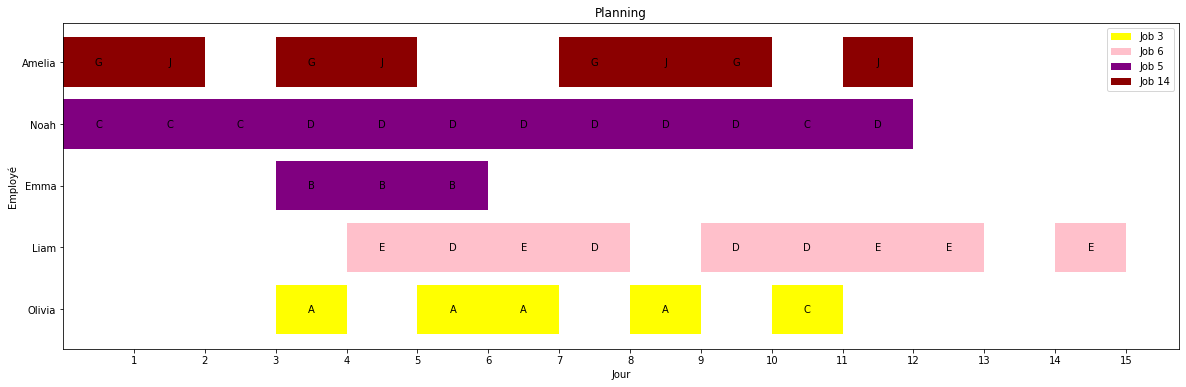

In [27]:
plot_planning(T)